In [11]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [13]:
# Optimization: predefine dtypes to speed up CSV read and reduce memory usage
dtype_map = {'label': 'int64'} | {str(i): 'uint8' for i in range(1, 785)}
df = pd.read_csv("Dataset//mnist_dataset.csv", dtype=dtype_map)

# Extract tensors directly from DataFrame
labels = torch.from_numpy(df['label'].values).to(torch.long)
pixels = torch.from_numpy(df.iloc[:, 1:].values).to(torch.float32)  # normalize in-place

# Optimization: train-test split using numpy, minimal conversion
indices = torch.arange(len(labels))
train_idx, test_idx = train_test_split(indices.numpy(), test_size=0.5, shuffle=True)

# Push to GPU during indexing to avoid data duplication
input_train = pixels[train_idx].to(device, non_blocking=True)/255
output_train = labels[train_idx].to(device, non_blocking=True)
input_test = pixels[test_idx].to(device, non_blocking=True)/255
output_test = labels[test_idx].to(device, non_blocking=True)

# Output dimensions (debug)
print("Train X:", input_train.shape)
print("Train Y:", output_train.shape)
print("Test X:", input_test.shape)
print("Test Y:", output_test.shape)


Train X: torch.Size([35000, 784])
Train Y: torch.Size([35000])
Test X: torch.Size([35000, 784])
Test Y: torch.Size([35000])


In [14]:
class LayerBlock(nn.Module):
    def __init__(self, input_size, output_size, activation='relu'):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size, bias=True)
        self.activation_name = activation.lower()

    def forward(self, x):
        z = self.linear(x)

        if self.activation_name == 'relu':
            return F.relu(z)
        elif self.activation_name == 'sigmoid':
            return torch.sigmoid(z)
        elif self.activation_name == 'softmax':
            return F.softmax(z, dim=1)
        else:
            return z  # Linear activation


In [15]:
class NNModel(nn.Module):
    def __init__(self, layer_sizes):
        super().__init__()
        self.layers = nn.ModuleList()
        self.layer_sizes = layer_sizes

        # Add layers
        for i in range(len(layer_sizes) - 1):
            activation = 'relu'
            if i == 0:
                activation = 'sigmoid'
            if i == len(layer_sizes) - 2:
                activation = 'softmax'
            self.layers.append(LayerBlock(layer_sizes[i], layer_sizes[i + 1], activation))

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


In [16]:
model = NNModel([784, 107, 26, 10]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Example training step
def train_one_epoch(model, optimizer, criterion, x, y):
    model.train()
    optimizer.zero_grad()
    output = model(x)
    loss = criterion(output, y)
    loss.backward()
    optimizer.step()
    return loss.item()


In [17]:
@torch.no_grad()
def evaluate(model, x, y):
    model.eval()
    preds = model(x).argmax(dim=1)
    accuracy = (preds == y).float().mean().item()
    return accuracy


In [18]:
import matplotlib.pyplot as plt

class Trainer:
    def __init__(self, model, optimizer, loss_fn, max_epochs=50):
        self.model = model
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.max_epochs = max_epochs
        self.loss_history = []

    def train(self, x_train, y_train):
        x_train = x_train.to(device)
        y_train = y_train.to(device)

        for epoch in range(self.max_epochs):
            self.model.train()
            self.optimizer.zero_grad()

            logits = self.model(x_train)
            loss = self.loss_fn(logits, y_train)

            loss.backward()
            self.optimizer.step()

            self.loss_history.append(loss.item())

            if epoch % 5 == 0 or epoch == self.max_epochs - 1:
                print(f"Epoch {epoch+1}/{self.max_epochs} - Loss: {loss.item():.4f}")

    def plot_loss(self):
        plt.plot(self.loss_history)
        plt.grid(True)
        plt.title("Training Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.show()


In [19]:
@torch.no_grad()
def evaluate(model, x, y):
    model.eval()
    x, y = x.to(device), y.to(device)
    pred = model(x).argmax(dim=1)
    acc = (pred == y).float().mean().item()
    print(f"Accuracy: {acc*100:.2f}%")
    return acc


Epoch 1/100 - Loss: 2.3027
Epoch 6/100 - Loss: 2.2969
Epoch 11/100 - Loss: 2.2897
Epoch 16/100 - Loss: 2.2802
Epoch 21/100 - Loss: 2.2671
Epoch 26/100 - Loss: 2.2489
Epoch 31/100 - Loss: 2.2248
Epoch 36/100 - Loss: 2.1945
Epoch 41/100 - Loss: 2.1592
Epoch 46/100 - Loss: 2.1214
Epoch 51/100 - Loss: 2.0831
Epoch 56/100 - Loss: 2.0458
Epoch 61/100 - Loss: 2.0111
Epoch 66/100 - Loss: 1.9793
Epoch 71/100 - Loss: 1.9500
Epoch 76/100 - Loss: 1.9230
Epoch 81/100 - Loss: 1.8990
Epoch 86/100 - Loss: 1.8774
Epoch 91/100 - Loss: 1.8580
Epoch 96/100 - Loss: 1.8402
Epoch 100/100 - Loss: 1.8273


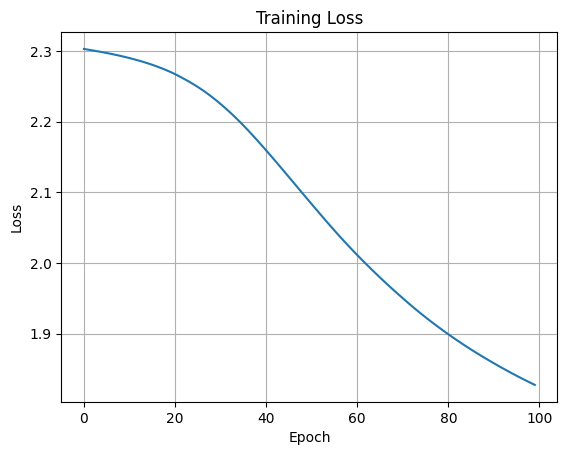

Accuracy: 70.32%


0.7032285928726196

In [20]:
# Build model
model = NNModel([784, 107, 26, 10]).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Train
trainer = Trainer(model, optimizer, loss_fn, max_epochs=100)
trainer.train(input_train, output_train)
trainer.plot_loss()

# Evaluate
evaluate(model, input_test, output_test)
